In [15]:
import googlemaps
import pandas as pd
import ast
import json
import pprint
import time
import geopy.distance
import Api_code


In [16]:
##---------------API KEY FOR GOOGLE------------##

gmaps = googlemaps.Client(key=Api_code.Api_Code)

In [9]:
##---------- The base file to get searching base as endaksa^^sehır,il,ilce^^---------##

endeksa = pd.read_csv("endeksa.csv")

##-------------This file will not be edited---------##

In [10]:
###--------------- FOR THE DATA COLLECTION MANUALLY ONLY FROM THE INTERNET (GOOGLE.API)----------------------##
###---------------FUNCTION WILL ONLY GET SEARCHED ITEMS ACCORDING TO THE ENDEKSA ORDER.
def data_collection_manual(searched_item,how_many_item):
    total = []
    step1 = gmaps.places(query = searched_item)
    step2 = json.dumps(step1)
    step3 = json.loads(step2)
    step4 = pd.DataFrame(step3["results"])
    total.append(step4.iloc[:how_many_item])
    step5 = pd.concat(total)
    return step5



In [11]:
## THE FUNCTION THAT COLLECTS EVERY PLACES THAT IS SEARCHED FROM THE ORDER IN THE "ENDEKSA" CSV FILE##

def data_collection_total(searching_key,how_many_results):
    total = []
    for i in range(0,len(endeksa)):
        
        search_loction = gmaps.places(query = endeksa["İL"][i] + " " + endeksa["İLÇE"][i] + " " + endeksa["MAHALLE"][i]+ " " + searching_key)
        file = json.dumps(search_loction)
        file_new = json.loads(file)
        df = pd.DataFrame(file_new["results"])
        total.append(df.iloc[:how_many_results])
        saved_file_name_beta = pd.concat(total)
    return saved_file_name_beta


In [12]:
##  SPLIT JSON LONGITUDE ALTITUDE VALUES INTO df AND REMOVE UNNECCESARY COLUMNS FOR ML ##

def api_data_adjustment(df):

    df["a"] = df["geometry"].astype(str).str.extract(':(.{,45})')
    df["b"] = df["a"].str.split(',').str[0]
    df["Latitude"] = df["b"].str[8:]
    df.drop(columns =["a","b"],axis = 1,inplace = True)
    df["c"] = df["geometry"].astype(str).str.split(",").str[1]
    df["d"] = df["c"].astype(str).str[7:]
    df["Longitude"] = df["d"].astype(str).str[:-1]
    df.drop(columns=["c","d"],axis=1,inplace=True)
    df.drop(columns=["geometry"],axis=1,inplace = True)
    df = df[["name","formatted_address","Latitude","Longitude"]]
    df.drop_duplicates(inplace = True)
    df.reset_index(drop=True, inplace=True)
    df["Latitude"] = pd.to_numeric(df["Latitude"])
    df["Longitude"] = pd.to_numeric(df["Longitude"])
    df["name"] = df["name"].astype(str)
    return df


In [13]:
###-----REMOVE UNNECESSARY VALUES THAT COMES FROM API SEARCHING(FALSE SEARCED RESULTS)--------##


def remove_unrelated(df,searched_word1,searched_word2):
    for i in range(0,len(df)):
        if searched_word1 not in df["name"][i] and searched_word2 not in df["name"][i] :
            df.drop([i], axis=0, inplace=True)
    return df

In [14]:
    ####--- It will clean the same results from different dataframes (dynobil_oppoent df will have dynobil locations by accident.They should be removed )---###

def same_loc_cleaner(changed_df,according_to):
     
     changed_df["marked"] = 0
     for j in range(0,len(changed_df)):
        for i in range(0,len(according_to)):
            if float(according_to["Longitude"][i])== float(changed_df["Longitude"][j]):
                changed_df["marked"][j] =  1
                
           
  
     for i in range(0,len(changed_df)):
        if changed_df["marked"][i] == 1:
            changed_df.drop([i],axis = 0 , inplace = True)
     changed_df.drop(columns =["marked"],axis = 0,inplace = True)
     
     return changed_df

In [15]:
###----Function will decide closest location from parameters---#####

def closest_calculation(origin,df_closest):
    rak = []
    rak_min = []
    if str(origin) != str(df_closest):

        for i in range (0,len(origin)):
            for j in range(0,len(df_closest)):
                rak.append(geopy.distance.geodesic((origin["Latitude"][i],origin["Longitude"][i]),(df_closest["Latitude"][j],df_closest["Longitude"][j])).km)
        
            rak_min.append(min(rak))
            rak = []
        return rak_min
    else:
        dyn = []
        dyn_min = [] 
        for i in range (0,len(origin)):
            for j in range(0,len(origin)):
                dyn.append(geopy.distance.geodesic((origin["Latitude"][i],origin["Longitude"][i]),(origin["Latitude"][j],origin["Longitude"][j])).km)
            dyn.sort()
            dyn_min.append(dyn[1])    
            dyn = [] 
        return dyn_min


In [16]:
import collections

def which_are_duplicated(df):
    df["duplicated"] = df.duplicated()
    a = []
    for i in range(0,len(df)):
        if df["duplicated"][i] == True:
            a.append(df.iloc[i])
    return a


In [17]:
dyno_data = data_collection_total("dynobil",2)


In [ ]:
alpha = api_data_adjustment(dyno_data)

In [ ]:
theta = alpha.sort_index().reset_index(drop=True)

In [ ]:
theta

,name,formatted_address,Latitude,Longitude
0,DYNOBİL Adana E5 Oto Ekspertiz,"Fevzipaşa, DYNOBİL OTO EKSPERTİZ, Turhan Cemal...",36.994788,35.282315
1,Dynobil Adana,"Ziyapaşa, Mustafa Kemal Paşa Blv. No:83/A, 011...",37.007448,35.325750
2,Ceyhan Oto Ekspertiz,"Ulus, Cevher Dudayev Sk. No:79, 01940 Ceyhan/A...",37.027978,35.820422
3,Adıyaman oto ekspertiz DYNOBİL kurumsal,"Altınşehir, 30151. Sk. No:3/A, 02040 Merkez/Ad...",37.739941,38.224598
4,DYNOBİL Dinar Oto Ekspertiz,"Yeni Sanayi Sitesi 03 Blok No:2, 03400 Dinar/A...",38.043999,30.108442
...,...,...,...,...
174,Dynobil Boğazlıyan Oto Ekspertiz,"Çarşı, Şht. Uğur Karasu Cd., 66402 Boğazlıyan/...",39.187543,35.244556
175,DYNOBİL Yozgat Oto Ekspertiz,Yozgat Ankara Yolu 4. Km Sarıhacılı Mah. Mevki...,39.807211,34.768585
176,Çaycuma Oto Ekspertiz,İstasyon Mahallesi İskele Caddesi Fetih Sokak ...,41.424095,32.093454
177,DYNOBİL KDZ.EREĞLİ OTO EKSPERTİZ (TSE BELGELİ),Kavaklık Mah.Devrek Yolu Cad.No:72/d (carrefou...,41.268321,31.456786


In [ ]:
#####ALL THE DYNOBIL LOCATIONS ARE SYCNED WITH ENDEKSA VALUES########

In [ ]:
dynobil_locations = theta

In [ ]:
####data collection for dynobil opponents######
first_part = data_collection_total("oto ekspertiz",20)
second_part = api_data_adjustment(first_part)
third_part = remove_unrelated(second_part,"ksper","KSPER")

In [ ]:
third_part = third_part.sort_index().reset_index(drop=True)

In [ ]:
third_part

,name,formatted_address,Latitude,Longitude,marked
0,Otorapor Adana Oto Ekspertiz,"Fevzipaşa, Turhan Cemal Beriker Blv. No:454/B,...",36.996703,35.257334,0
1,Pilot Garage Oto Ekspertiz Çukurova,"Fevzipaşa, Turhan Cemal Beriker Blv. No:270/A,...",36.994854,35.283201,0
2,AUTO ANALİZ Adana Oto Ekspertiz,"Kiza İş Merkezi, Onur Mah. Turhan Cemal Berike...",36.996644,35.262918,0
3,GarantiliArabam Oto Ekspertiz Adana,"Şakirpaşa, Turhan Cemal Beriker Blv. No: 299 ,...",36.994892,35.275678,0
4,Auto Kale Oto Ekspertiz Adana,"Adana Otogarı karşısı,Onur Mah.Turhan Cemal Be...",36.996144,35.257459,0
...,...,...,...,...,...
1272,Otorapor Çaycuma Oto Ekspertiz,"İstasyon, Yeşil Sanayi 2. sk D: blok No:29, 67...",41.411389,32.087533,0
1273,Pilot Garage Oto Ekspertiz Kdz. Ereğli,"Belen Yeni, 1 Nolu Sanayi Cd. A Blok Sk. no:16...",41.271991,31.486470,0
1274,Oto Rapor - Oto Ekspertiz Zonguldak Merkez,"10 Temmuz Mah. Belediye Bulvarı, Acılık Cd. No...",41.448590,31.791395,0
1275,PİLOT GARAGE OTO EKSPERTİZ,"Çınartepe, Karaelmas Küçük Sanayi Sitesi, 4B B...",41.477220,31.864789,0


In [ ]:
dynobil_oponents = same_loc_cleaner(third_part,dynobil_locations)

In [ ]:
dynobil_oponents

,name,formatted_address,Latitude,Longitude
0,Otorapor Adana Oto Ekspertiz,"Fevzipaşa, Turhan Cemal Beriker Blv. No:454/B,...",36.996703,35.257334
1,Pilot Garage Oto Ekspertiz Çukurova,"Fevzipaşa, Turhan Cemal Beriker Blv. No:270/A,...",36.994854,35.283201
2,AUTO ANALİZ Adana Oto Ekspertiz,"Kiza İş Merkezi, Onur Mah. Turhan Cemal Berike...",36.996644,35.262918
3,GarantiliArabam Oto Ekspertiz Adana,"Şakirpaşa, Turhan Cemal Beriker Blv. No: 299 ,...",36.994892,35.275678
4,Auto Kale Oto Ekspertiz Adana,"Adana Otogarı karşısı,Onur Mah.Turhan Cemal Be...",36.996144,35.257459
...,...,...,...,...
1272,Otorapor Çaycuma Oto Ekspertiz,"İstasyon, Yeşil Sanayi 2. sk D: blok No:29, 67...",41.411389,32.087533
1273,Pilot Garage Oto Ekspertiz Kdz. Ereğli,"Belen Yeni, 1 Nolu Sanayi Cd. A Blok Sk. no:16...",41.271991,31.486470
1274,Oto Rapor - Oto Ekspertiz Zonguldak Merkez,"10 Temmuz Mah. Belediye Bulvarı, Acılık Cd. No...",41.448590,31.791395
1275,PİLOT GARAGE OTO EKSPERTİZ,"Çınartepe, Karaelmas Küçük Sanayi Sitesi, 4B B...",41.477220,31.864789


In [ ]:
####data collection for NOTER######
first_part1 = data_collection_total("noter",20)
second_part2 = api_data_adjustment(first_part1)
third_part3 = remove_unrelated(second_part2,"oter","OTER")
third_part3 = third_part3.sort_index().reset_index(drop=True)
Noter = same_loc_cleaner(third_part3,dynobil_locations)

In [ ]:
####data collection for GALERI######
first_part11 = data_collection_total("oto galeri",20)
second_part22 = api_data_adjustment(first_part11)
third_part33 = remove_unrelated(second_part22,"aler","ALER")
third_part33 = third_part33.sort_index().reset_index(drop=True)
Galeri = same_loc_cleaner(third_part33,dynobil_locations)

In [ ]:
Galeri

,name,formatted_address,Latitude,Longitude
0,Adalı Oto Galeri,"Ziyapaşa, 67038. Sk. No:66, 01140 Seyhan/Adana...",37.007312,35.327948
1,Adil Oto Galeri,"Kaltakiye, İnönü Blv., 01960 Ceyhan/Adana, Turkey",37.030899,35.817445
2,Coskun Galeri,"Kaltakiye, Dr. Mahir Alp Boydak Cd., 01960 Cey...",37.031400,35.812020
3,Hakim Oto Galeri,"Kaltakiye, Emin Civelek Cd, 01960 Ceyhan/Adana...",37.032437,35.814538
4,Tarisu Oto Galeri,"Kaltakiye, Emin Civelek Cd, 01960 Ceyhan/Adana...",37.032581,35.817050
...,...,...,...,...
258,Galeri 64 - Muhammer Kahraman,Fevzi Çakmak Mah. Halil Kaya Gedik Bulv. 1. Ga...,38.653331,29.443148
259,Galeri Aydoğan,"Gazi Osman Paşa, 77100 Yalova Merkez/Yalova, T...",40.633487,29.275947
260,Afşarlar Gayrimenkul Rentekar & Oto Galeri,"Gazi Osman Paşa, Burçak Sk., 77100 Yalova Merk...",40.646176,29.284820
261,Hars Traktör Erdemler Oto Galeri,"Aşağı, 66400 Boğazlıyan/Yozgat, Turkey",39.186088,35.240454


In [ ]:
###----- CALCULATING CLOSEST DYNOBIL LOCATIONS-----###


closest_dynobil = closest_calculation(dynobil_locations,dynobil_locations)
closest_oponent = closest_calculation(dynobil_locations,dynobil_oponents)
closest_noter = closest_calculation(dynobil_locations,Noter)
closest_galeri = closest_calculation(dynobil_locations,Galeri)

In [ ]:
### EDITING THE ENDEKSA VALUES FOR ML ALGORITHM###
unedited_endeksa = pd.read_csv("endeksa.csv")


In [ ]:
unedited_endeksa

,İL,İLÇE,MAHALLE,NÜFUS,NÜFUS_YOĞ.,EĞİTİM_DÜZEYİ,SOSYO_EKONOMİK_STATÜ,HANE_HALKI,TÜKETİM_EĞİLİMLERİ,GAYRİMENKUL_İŞLEMLERİ,GAYRİMENKUL_DAĞILIMI
0,ADANA,SEYHAN,FEVZİPAŞA,13110.0,10404.0,İLKOKUL,B,3.58,3717.0,282.0,6036.0
1,ADANA,SEYHAN,ZİYAPAŞA,8461.0,10193.0,LİSE,C,3.60,5244.0,69.0,4418.0
2,ADANA,CEYHAN,ULUS,5180.0,11511.0,LİSE,C,3.67,4009.0,160.0,2021.0
3,ADIYAMAN,MERKEZ,ALTINŞEHİR,21049.0,1525.0,LİSE,C,4.15,3749.0,NaN,NaN
4,AFYON,DİNAR,DİNAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
174,YOZGAT,BOĞAZLIYAN,ÇARŞI,1893.0,2524.0,İLKOKUL,C,2.84,3924.0,NaN,NaN
175,YOZGAT,MERKEZ,SARIHACILI,146.0,6.3,İLKOKUL,D,NaN,1870.0,NaN,NaN
176,ZONGULDAK,ÇAYCUMA,İSTASYON,3431.0,907.0,İLKOKUL,C,3.06,4463.0,48.0,3657.0
177,ZONGULDAK,EREĞLİ,KAVAKLIK,6234.0,7992.0,LİSE,C,3.75,2998.0,172.0,3028.0


In [ ]:
unedited_endeksa = unedited_endeksa.drop(columns=["İL","İLÇE","MAHALLE"])

In [ ]:
unedited_endeksa.dtypes

NÜFUS                    float64
NÜFUS_YOĞ.               float64
EĞİTİM_DÜZEYİ             object
SOSYO_EKONOMİK_STATÜ      object
HANE_HALKI               float64
TÜKETİM_EĞİLİMLERİ       float64
GAYRİMENKUL_İŞLEMLERİ    float64
GAYRİMENKUL_DAĞILIMI     float64
dtype: object

In [ ]:
unedited_endeksa.isnull().sum()

NÜFUS                     5
NÜFUS_YOĞ.                5
EĞİTİM_DÜZEYİ             6
SOSYO_EKONOMİK_STATÜ      6
HANE_HALKI                7
TÜKETİM_EĞİLİMLERİ        6
GAYRİMENKUL_İŞLEMLERİ    34
GAYRİMENKUL_DAĞILIMI     34
dtype: int64

In [ ]:
unedited_endeksa["GAYRİMENKUL_İŞLEMLERİ"].fillna(unedited_endeksa["GAYRİMENKUL_İŞLEMLERİ"].median(skipna=True), inplace=True)


In [ ]:
unedited_endeksa["GAYRİMENKUL_DAĞILIMI"].fillna(unedited_endeksa["GAYRİMENKUL_DAĞILIMI"].median(skipna=True), inplace=True)

In [ ]:
unedited_endeksa.isnull().sum()

NÜFUS                    5
NÜFUS_YOĞ.               5
EĞİTİM_DÜZEYİ            6
SOSYO_EKONOMİK_STATÜ     6
HANE_HALKI               7
TÜKETİM_EĞİLİMLERİ       6
GAYRİMENKUL_İŞLEMLERİ    0
GAYRİMENKUL_DAĞILIMI     0
dtype: int64

In [ ]:
unedited_endeksa["TÜKETİM_EĞİLİMLERİ"].fillna(unedited_endeksa["TÜKETİM_EĞİLİMLERİ"].median(skipna=True), inplace=True)
unedited_endeksa["HANE_HALKI"].fillna(unedited_endeksa["HANE_HALKI"].median(skipna=True), inplace=True)
unedited_endeksa["NÜFUS"].fillna(unedited_endeksa["NÜFUS"].median(skipna=True), inplace=True)
unedited_endeksa["NÜFUS_YOĞ."].fillna(unedited_endeksa["NÜFUS_YOĞ."].median(skipna=True), inplace=True)

In [ ]:
unedited_endeksa.isnull().sum()

NÜFUS                    0
NÜFUS_YOĞ.               0
EĞİTİM_DÜZEYİ            6
SOSYO_EKONOMİK_STATÜ     6
HANE_HALKI               0
TÜKETİM_EĞİLİMLERİ       0
GAYRİMENKUL_İŞLEMLERİ    0
GAYRİMENKUL_DAĞILIMI     0
dtype: int64

[Text(0.5, 0, 'Age')]

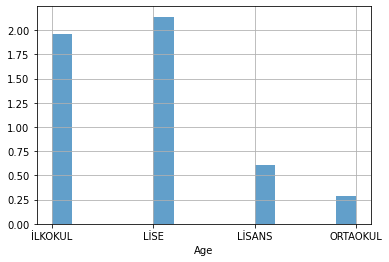

In [ ]:
import matplotlib as plt

ax = unedited_endeksa['EĞİTİM_DÜZEYİ'].hist(bins=15, density=True, stacked=True, alpha=0.7)
ax.set(xlabel='Age')


[Text(0.5, 0, 'Age')]

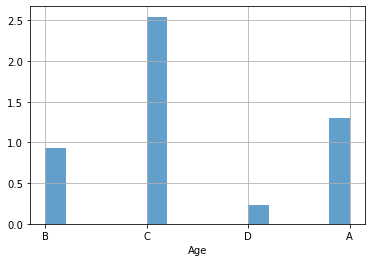

In [ ]:
ax = unedited_endeksa['SOSYO_EKONOMİK_STATÜ'].hist(bins=15, density=True, stacked=True, alpha=0.7)
ax.set(xlabel='Age')

In [ ]:
unedited_endeksa['EĞİTİM_DÜZEYİ'].fillna("LİSE",inplace=True)

In [ ]:
unedited_endeksa['SOSYO_EKONOMİK_STATÜ'].fillna("C",inplace=True)

In [ ]:
unedited_endeksa

,NÜFUS,NÜFUS_YOĞ.,EĞİTİM_DÜZEYİ,SOSYO_EKONOMİK_STATÜ,HANE_HALKI,TÜKETİM_EĞİLİMLERİ,GAYRİMENKUL_İŞLEMLERİ,GAYRİMENKUL_DAĞILIMI
0,13110.0,10404.0,İLKOKUL,B,3.580,3717.0,282.0,6036.0
1,8461.0,10193.0,LİSE,C,3.600,5244.0,69.0,4418.0
2,5180.0,11511.0,LİSE,C,3.670,4009.0,160.0,2021.0
3,21049.0,1525.0,LİSE,C,4.150,3749.0,218.0,5122.0
4,8398.5,4443.5,LİSE,C,3.205,4238.0,218.0,5122.0
...,...,...,...,...,...,...,...,...
174,1893.0,2524.0,İLKOKUL,C,2.840,3924.0,218.0,5122.0
175,146.0,6.3,İLKOKUL,D,3.205,1870.0,218.0,5122.0
176,3431.0,907.0,İLKOKUL,C,3.060,4463.0,48.0,3657.0
177,6234.0,7992.0,LİSE,C,3.750,2998.0,172.0,3028.0


In [ ]:
unedited_endeksa = pd.get_dummies(unedited_endeksa, columns=["EĞİTİM_DÜZEYİ","SOSYO_EKONOMİK_STATÜ"])

In [ ]:
main = dynobil_locations

In [ ]:
main["closest_dynobil"] = closest_dynobil
main["closest_oponent"] = closest_oponent
main["closest_noter"] = closest_noter
main["closest_galeri"] = closest_galeri


In [ ]:
main = pd.concat([main,unedited_endeksa],axis =1)

In [35]:
####---I DO NOT WANT TO USE API REQUEST SO I JUST UPLOAD FROM CSV-----#######

main = pd.read_csv("main.csv")

In [38]:
main = main.iloc[:, :-2]

In [39]:
main

,Unnamed: 0,name,formatted_address,Latitude,Longitude,closest_dynobil,closest_oponent,closest_noter,closest_galeri,NÜFUS,NÜFUS_YOĞ.,EĞİTİM_DÜZEYİ,SOSYO_EKONOMİK_STATÜ,HANE_HALKI,TÜKETİM_EĞİLİMLERİ,GAYRİMENKUL_İŞLEMLERİ,GAYRİMENKUL_DAĞILIMI
0,0,DYNOBİL Adana E5 Oto Ekspertiz,"Fevzipaşa, DYNOBİL OTO EKSPERTİZ, Turhan Cemal...",36.994788,35.282315,4.113551,0.079223,2.784240,4.293019,13110.0,10404.0,İLKOKUL,B,3.580,3717.0,282.0,6036.0
1,1,Dynobil Adana,"Ziyapaşa, Mustafa Kemal Paşa Blv. No:83/A, 011...",37.007448,35.325750,4.113551,0.018805,0.126275,0.196161,8461.0,10193.0,LİSE,C,3.600,5244.0,69.0,4418.0
2,2,Ceyhan Oto Ekspertiz,"Ulus, Cevher Dudayev Sk. No:79, 01940 Ceyhan/A...",37.027978,35.820422,35.887626,0.137597,0.523788,0.418587,5180.0,11511.0,LİSE,C,3.670,4009.0,160.0,2021.0
3,3,Adıyaman oto ekspertiz DYNOBİL kurumsal,"Altınşehir, 30151. Sk. No:3/A, 02040 Merkez/Ad...",37.739941,38.224598,68.289887,0.580170,0.784482,0.280189,21049.0,1525.0,LİSE,C,4.150,3749.0,218.0,5122.0
4,4,DYNOBİL Dinar Oto Ekspertiz,"Yeni Sanayi Sitesi 03 Blok No:2, 03400 Dinar/A...",38.043999,30.108442,38.738783,5.330874,5.764948,5.032759,8398.5,4443.5,LİSE,C,3.205,4238.0,218.0,5122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,174,Dynobil Boğazlıyan Oto Ekspertiz,"Çarşı, Şht. Uğur Karasu Cd., 66402 Boğazlıyan/...",39.187543,35.244556,52.943189,21.167093,0.390659,0.389481,1893.0,2524.0,İLKOKUL,C,2.840,3924.0,218.0,5122.0
175,175,DYNOBİL Yozgat Oto Ekspertiz,Yozgat Ankara Yolu 4. Km Sarıhacılı Mah. Mevki...,39.807211,34.768585,80.058683,2.104900,3.718215,80.018267,146.0,6.3,İLKOKUL,D,3.205,1870.0,218.0,5122.0
176,176,Çaycuma Oto Ekspertiz,İstasyon Mahallesi İskele Caddesi Fetih Sokak ...,41.424095,32.093454,25.821217,1.495566,1.425709,0.210159,3431.0,907.0,İLKOKUL,C,3.060,4463.0,48.0,3657.0
177,177,DYNOBİL KDZ.EREĞLİ OTO EKSPERTİZ (TSE BELGELİ),Kavaklık Mah.Devrek Yolu Cad.No:72/d (carrefou...,41.268321,31.456786,34.109224,2.520423,1.964068,54.127383,6234.0,7992.0,LİSE,C,3.750,2998.0,172.0,3028.0


In [40]:
main = pd.get_dummies(main, columns=["EĞİTİM_DÜZEYİ","SOSYO_EKONOMİK_STATÜ"])

In [42]:
main.to_csv("main.csv")